In [4]:
import stim 
import numpy as np
import networkx as nx
from css import *
from graphs import edge_coloring
edge_color_bipartite = edge_coloring.edge_color_bipartite

In [5]:
sfcode3 = SurfaceCode(d=3)
sfcode3.H_X, sfcode3.H_Z

(array([[1, 1, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 1, 1]]),
 array([[1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 1, 1, 0, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 1]]))

In [6]:
sfcode3.L_X, sfcode3.L_Z
#Notice that Lz is diagonal 

(array([[0, 0, 0, 0, 0, 0, 1, 1, 1]], dtype=uint8),
 array([[1, 0, 0, 0, 1, 0, 0, 0, 1]], dtype=uint8))

In [7]:
from sec_circuits.sec_static import stim_circuit_from_checks as stim_circuit_from_checks

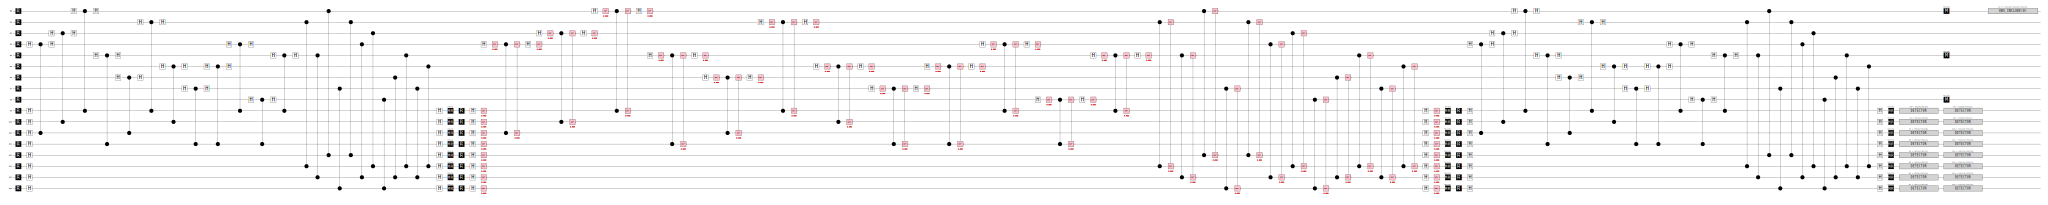

In [8]:
Hx = sfcode3.H_X
Hz = sfcode3.H_Z
Lx = sfcode3.L_X
Lz = sfcode3.L_Z
circuit = stim_circuit_from_checks(Hx, Hz, logical_obs_qubits=Lz, num_rounds=1, p1=0.003, p2=0.003)
circuit.diagram("timeline-svg")

In [9]:
import pymatching

d = 7
sfcode = SurfaceCode(d=d)
Hx = sfcode.H_X
Hz = sfcode.H_Z
Lx = sfcode.L_X
Lz = sfcode.L_Z
noise = 0.001
circuit = stim_circuit_from_checks(
            Hx,
            Hz,
            logical_obs_qubits=Lz,
            num_rounds=d * 3,
            p1=noise,
            p2=noise,
        )

model = circuit.detector_error_model(decompose_errors=True)
matching = pymatching.Matching.from_detector_error_model(model)
sampler = circuit.compile_detector_sampler()
syndrome, actual_observables = sampler.sample(shots=100000, separate_observables=True)

In [10]:
num_errors = 0
for i in range(syndrome.shape[0]):
    predicted_observables = matching.decode(syndrome[i, :])
    num_errors += not np.array_equal(actual_observables[i, :], predicted_observables)

print(num_errors)  # prints 8

85


In [ ]:
import matplotlib.pyplot as plt
def run_threshold(
    code_type="surface",  # or "toric"
    distances=[5, 7, 9], 
    noise_rates=[0.001, 0.005, 0.009, 0.013], 
    shots=10000
):
    """Run threshold simulation for either surface or toric code.
    
    Args:
        code_type: Either "surface" or "toric" to specify code type
        distances: List of code distances to test
        noise_rates: List of physical error rates to test
        shots: Number of shots to sample for each configuration
        
    Returns:
        Tuple of (distances, noise_rates, logical_error_rates)
    """
    # Store results: logical_error_rates[d_idx][noise_idx]
    logical_error_rates = np.zeros((len(distances), len(noise_rates)))
    
    for d_idx, d in enumerate(distances):
        print(f"Running distance d={d}...")
        
        # Initialize appropriate code
        if code_type == "surface":
            code = SurfaceCode(d=d)
        elif code_type == "toric":
            code = ToricCode(d=d)
        else:
            raise ValueError(f"Unknown code_type: {code_type}")
            
        Hx = code.H_X
        Hz = code.H_Z
        Lx = code.L_X
        Lz = code.L_Z
        
        for noise_idx, noise in enumerate(noise_rates):
            print(f"  Testing noise rate p={noise:.3f}...")
            
            # Create circuit
            circuit = stim_circuit_from_checks(
                Hx,
                Hz,
                logical_obs_qubits=Lz,
                num_rounds=d * 3,  
                p1=noise,
                p2=noise,
            )
            
            # Create matching model
            model = circuit.detector_error_model(decompose_errors=True)
            matching = pymatching.Matching.from_detector_error_model(model)
            
            # Sample and decode
            sampler = circuit.compile_detector_sampler()
            syndrome, actual_observables = sampler.sample(shots=shots, separate_observables=True)
            
            # Decode and count errors
            predicted_observables = matching.decode_batch(syndrome)
            errors = np.any(predicted_observables != actual_observables, axis=1)
            error_rate = np.mean(errors)
            
            logical_error_rates[d_idx, noise_idx] = error_rate
            print(f"    Logical error rate: {error_rate:.4f}")
    
    return distances, noise_rates, logical_error_rates


In [12]:
# Run the surface code memory experiment
distances, noise_rates, logical_error_rates = distances, noise_rates, logical_error_rates = run_threshold(code_type="surface",
    distances=[5, 7, 9], 
    noise_rates=[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012], 
    shots=10000)


Running distance d=5...
  Testing noise rate p=0.001...
    Logical error rate: 0.0040
  Testing noise rate p=0.002...
    Logical error rate: 0.0164
  Testing noise rate p=0.003...
    Logical error rate: 0.0395
  Testing noise rate p=0.004...
    Logical error rate: 0.0834
  Testing noise rate p=0.005...
    Logical error rate: 0.1297
  Testing noise rate p=0.006...
    Logical error rate: 0.1825
  Testing noise rate p=0.007...
    Logical error rate: 0.2423
  Testing noise rate p=0.008...
    Logical error rate: 0.2958
  Testing noise rate p=0.009...
    Logical error rate: 0.3416
  Testing noise rate p=0.010...
    Logical error rate: 0.3818
  Testing noise rate p=0.011...
    Logical error rate: 0.4101
  Testing noise rate p=0.012...
    Logical error rate: 0.4404
Running distance d=7...
  Testing noise rate p=0.001...
    Logical error rate: 0.0009
  Testing noise rate p=0.002...
    Logical error rate: 0.0083
  Testing noise rate p=0.003...
    Logical error rate: 0.0295
  Testi

In [ ]:
# Save data. IMPORTANT!

In [ ]:
# After running the experiment
np.savez('threshold_data_static.npz', 
         distances=distances, 
         noise_rates=noise_rates, 
         logical_error_rates=logical_error_rates,
         code_type="surface")


In [ ]:
# Later, to load and plot:
data = np.load('threshold_data_static.npz')
distances = data['distances']
noise_rates = data['noise_rates']
logical_error_rates = data['logical_error_rates']


PLOT FIGURE

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


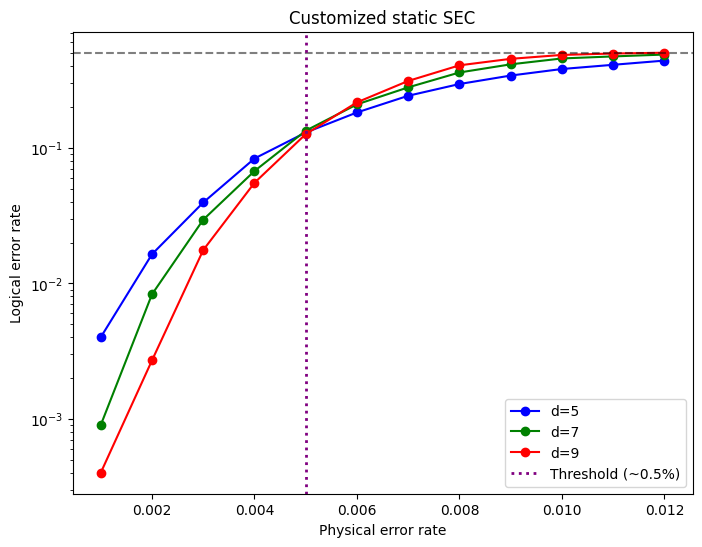

In [ ]:
plt.figure(figsize=(8, 6))
colors = ['b', 'g', 'r']

for d_idx, d in enumerate(distances):
	plt.plot(noise_rates, logical_error_rates[d_idx], 
				'o-', color=colors[d_idx], label=f'd={d}')

plt.axhline(0.5, color='k', linestyle='--', alpha=0.5)
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
threshold_p = 0.005  
plt.axvline(x=threshold_p, color='purple', linestyle=':', linewidth=2, 
            label=f"Threshold (~{threshold_p*100:.1f}%)")
# plt.axvspan(0.001, 0.005, color='purple', alpha=0.1, label="Threshold region")

plt.title('Customized static SEC')
plt.legend()
# plt.grid(True)

plt.yscale('log')

plt.savefig('static_threshold_customized.eps')
plt.show()
# Surface code threshold experiment with deterministic CZs

In [51]:
import stim
import numpy as np
import pymatching

def run_stim_builtin_surface_code(
    distances=[5, 7, 9],
    noise_rates=[0.001, 0.003, 0.005, 0.007, 0.009, 0.011, 0.013],
    shots=10000
):
    logical_error_rates = np.zeros((len(distances), len(noise_rates)))

    for d_idx, d in enumerate(distances):
        print(f"Running d = {d}")
        rounds = d * 3
        for p_idx, p in enumerate(noise_rates):
            print(f"  Noise rate p = {p:.4f}")

            # Generate circuit
            circuit = stim.Circuit.generated(
                "surface_code:rotated_memory_z",
                distance=d,
                rounds=rounds,
                after_clifford_depolarization=p
            )

            # Create detector error model and matching decoder
            model = circuit.detector_error_model(decompose_errors=True)
            matching = pymatching.Matching.from_detector_error_model(model)

            # Sample circuit
            sampler = circuit.compile_detector_sampler()
            dets, obs = sampler.sample(shots=shots, separate_observables=True)

            # Decode
            preds = matching.decode_batch(dets)
            errors = np.any(preds != obs, axis=1)
            error_rate = np.mean(errors)

            logical_error_rates[d_idx, p_idx] = error_rate
            print(f"    Logical error rate: {error_rate:.4f}")

    return distances, noise_rates, logical_error_rates


In [52]:
dists2, ps2, logicals2 = run_stim_builtin_surface_code(
    distances=[5, 7, 9],
    noise_rates=[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012, 0.013],
    shots=10000
)


Running d = 5
  Noise rate p = 0.0010
    Logical error rate: 0.0000
  Noise rate p = 0.0020
    Logical error rate: 0.0006
  Noise rate p = 0.0030
    Logical error rate: 0.0026
  Noise rate p = 0.0040
    Logical error rate: 0.0077
  Noise rate p = 0.0050
    Logical error rate: 0.0119
  Noise rate p = 0.0060
    Logical error rate: 0.0217
  Noise rate p = 0.0070
    Logical error rate: 0.0360
  Noise rate p = 0.0080
    Logical error rate: 0.0508
  Noise rate p = 0.0090
    Logical error rate: 0.0675
  Noise rate p = 0.0100
    Logical error rate: 0.0847
  Noise rate p = 0.0110
    Logical error rate: 0.1075
  Noise rate p = 0.0120
    Logical error rate: 0.1308
  Noise rate p = 0.0130
    Logical error rate: 0.1623
Running d = 7
  Noise rate p = 0.0010
    Logical error rate: 0.0000
  Noise rate p = 0.0020
    Logical error rate: 0.0004
  Noise rate p = 0.0030
    Logical error rate: 0.0012
  Noise rate p = 0.0040
    Logical error rate: 0.0041
  Noise rate p = 0.0050
    Logical e

In [ ]:
plt.figure(figsize=(8, 6))
colors = ['b', 'g', 'r']

for d_idx, d in enumerate(distances):
	plt.plot(noise_rates, logicals2[d_idx], 
				'o-', color=colors[d_idx], label=f'd={d}')

plt.axhline(0.5, color='k', linestyle='--', alpha=0.5)
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
threshold_p = 0.005  
plt.axvline(x=threshold_p, color='purple', linestyle=':', linewidth=2, 
            label=f"Threshold (~{threshold_p*100:.1f}%)")
# plt.axvspan(0.001, 0.005, color='purple', alpha=0.1, label="Threshold region")

plt.title('Customized static SEC')
plt.legend()
# plt.grid(True)

plt.yscale('log')

plt.savefig('static_threshold_customized.eps')
plt.show()
# Surface code threshold experiment with deterministic CZs

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


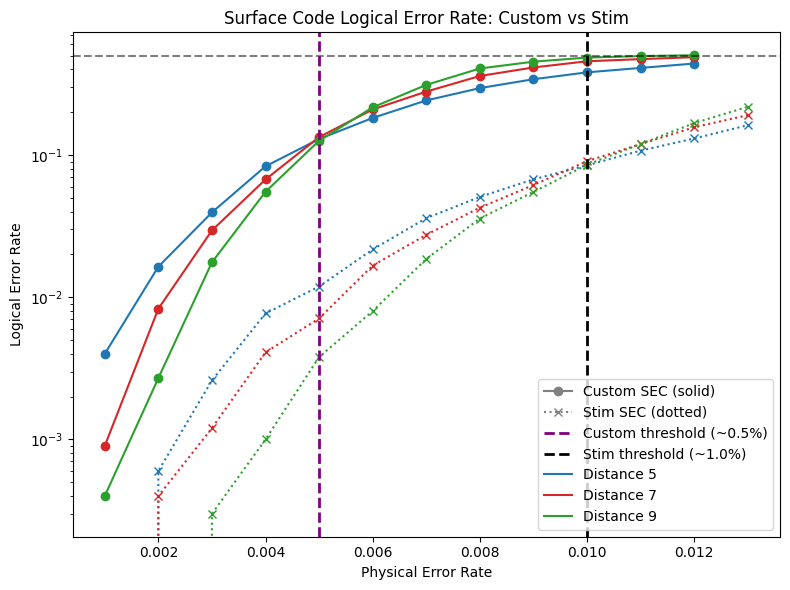

In [74]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Choose soft, publication-friendly colors
colors = {
    5: '#1f77b4',   # blue
    7: '#d62728',   # red
    9: '#2ca02c',   # green
}

plt.figure(figsize=(8, 6))

# Plot curves for each distance
for i, d in enumerate(dists1):
    color = colors[d]
    # Custom circuit: solid line with circles
    plt.plot(ps1, logicals1[i], 'o-', color=color)
    # Stim circuit: dotted line with x markers
    plt.plot(ps2, logicals2[i], 'x:', color=color)

# Threshold lines
threshold_p_custom = 0.005
threshold_p_stim = 0.01
plt.axhline(0.5, color='k', linestyle='--', alpha=0.5)

plt.axvline(x=threshold_p_custom, color='purple', linestyle='--', linewidth=2)
plt.axvline(x=threshold_p_stim, color='black', linestyle='--', linewidth=2)

# Axes labels and formatting
plt.xlabel("Physical Error Rate")
plt.ylabel("Logical Error Rate")
plt.yscale("log")
plt.title("Surface Code Logical Error Rate: Custom vs Stim")

# Remove this line to eliminate the grid
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Custom legend with grouped elements
legend_elements = [
    Line2D([0], [0], color='gray', marker='o', linestyle='-', label='Custom SEC (solid)'),
    Line2D([0], [0], color='gray', marker='x', linestyle=':', label='Stim SEC (dotted)'),
    Line2D([0], [0], color='purple', linestyle='--', linewidth=2, label=f"Custom threshold (~{threshold_p_custom*100:.1f}%)"),
    Line2D([0], [0], color='black', linestyle='--', linewidth=2, label="Stim threshold (~1.0%)"),
]

# Add distance legend entries with correct colors (no duplicates)
for d in dists1:
    legend_elements.append(Line2D([0], [0], color=colors[d], linestyle='-', label=f"Distance {d}"))

# Final legend and display
plt.legend(handles=legend_elements, loc='lower right')
plt.tight_layout()
plt.savefig('static_threshold_custom_and_stim.eps')

plt.show()

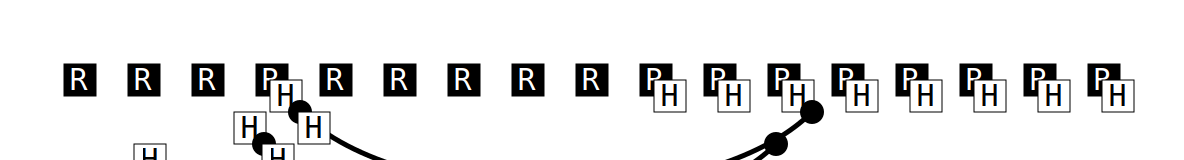

In [ ]:
Hx = sfcode3.H_X
Hz = sfcode3.H_Z
Lx = sfcode3.L_X
Lz = sfcode3.L_Z
circuit = stim_circuit_from_checks(Hx, Hz, logical_obs_qubits=Lz, num_rounds=1, p1=0.003, p2=0.003)
circuit.diagram("timeslice-svg")

In [47]:
circuit.diagram("timeline-3d")

{"accessors":[{"bufferView":0,"byteOffset":0,"componentType":5126,"count":12,"max":[0,0.5,0.5],"min":[0,-0.5,-0.5],"name":"cube","type":"VEC3"},{"bufferView":1,"byteOffset":0,"componentType":5126,"count":12,"max":[0.375,0.5625],"min":[0.3125,0.5],"name":"tex_coords_gate_R","type":"VEC2"},{"bufferView":2,"byteOffset":0,"componentType":5126,"count":12,"max":[0.125,0.5],"min":[0.0625,0.4375],"name":"tex_coords_gate_H","type":"VEC2"},{"bufferView":3,"byteOffset":0,"componentType":5126,"count":17,"max":[0,0.400000005960464,0.400000005960464],"min":[0,-0.400000005960464,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":4,"byteOffset":0,"componentType":5126,"count":12,"max":[0.4375,0.5625],"min":[0.375,0.5],"name":"tex_coords_gate_MR","type":"VEC2"},{"bufferView":5,"byteOffset":0,"componentType":5126,"count":12,"max":[0.25,0.625],"min":[0.1875,0.5625],"name":"tex_coords_gate_DEPOLARIZE1","type":"VEC2"},{"bufferView":6,"byteOffset":0,"componentType":5126,"count":12,"max":[0.3125,0.625],"min":[0.25,0.5625],"name":"tex_coords_gate_DEPOLARIZE2","type":"VEC2"},{"bufferView":7,"byteOffset":0,"componentType":5126,"count":12,"max":[0.3125,0.5625],"min":[0.25,0.5],"name":"tex_coords_gate_M","type":"VEC2"},{"bufferView":8,"byteOffset":0,"componentType":5126,"count":418,"max":[1,-0,-0],"min":[-142,-32,-0],"name":"buf_scattered_lines","type":"VEC3"},{"bufferView":9,"byteOffset":0,"componentType":5126,"count":6,"max":[0,2.5,-0],"min":[-3,1.5,-0],"name":"buf_red_scattered_lines","type":"VEC3"}],"asset":{"version":"2.0"},"bufferViews":[{"buffer":0,"byteLength":144,"byteOffset":0,"name":"cube","target":34962},{"buffer":1,"byteLength":96,"byteOffset":0,"name":"tex_coords_gate_R","target":34962},{"buffer":2,"byteLength":96,"byteOffset":0,"name":"tex_coords_gate_H","target":34962},{"buffer":3,"byteLength":204,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":4,"byteLength":96,"byteOffset":0,"name":"tex_coords_gate_MR","target":34962},{"buffer":5,"byteLength":96,"byteOffset":0,"name":"tex_coords_gate_DEPOLARIZE1","target":34962},{"buffer":6,"byteLength":96,"byteOffset":0,"name":"tex_coords_gate_DEPOLARIZE2","target":34962},{"buffer":7,"byteLength":96,"byteOffset":0,"name":"tex_coords_gate_M","target":34962},{"buffer":8,"byteLength":5016,"byteOffset":0,"name":"buf_scattered_lines","target":34962},{"buffer":9,"byteLength":72,"byteOffset":0,"name":"buf_red_scattered_lines","target":34962}],"buffers":[{"byteLength":144,"name":"cube","uri":"data:application/octet-stream;base64,AAAAAAAAAD8AAAA/AAAAAAAAAD8AAAC/AAAAAAAAAL8AAAA/AAAAAAAAAD8AAAC/AAAAAAAAAL8AAAC/AAAAAAAAAL8AAAA/AAAAAAAAAL8AAAC/AAAAAAAAAD8AAAC/AAAAAAAAAL8AAAA/AAAAAAAAAL8AAAA/AAAAAAAAAD8AAAC/AAAAAAAAAD8AAAA/"},{"byteLength":96,"name":"tex_coords_gate_R","uri":"data:application/octet-stream;base64,AADAPgAAAD8AAKA+AAAAPwAAwD4AABA/AACgPgAAAD8AAKA+AAAQPwAAwD4AABA/AADAPgAAED8AAMA+AAAAPwAAoD4AABA/AACgPgAAED8AAMA+AAAAPwAAoD4AAAA/"},{"byteLength":96,"name":"tex_coords_gate_H","uri":"data:application/octet-stream;base64,AAAAPgAA4D4AAIA9AADgPgAAAD4AAAA/AACAPQAA4D4AAIA9AAAAPwAAAD4AAAA/AAAAPgAAAD8AAAA+AADgPgAAgD0AAAA/AACAPQAAAD8AAAA+AADgPgAAgD0AAOA+"},{"byteLength":204,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAM3MzD4AAAAAAAAAAOU1vT5Fvxw+AAAAAMPQkD7D0JA+AAAAAES/HD7lNb0+AAAAAPIwlrLNzMw+AAAAAEe/HL7lNb0+AAAAAMPQkL7D0JA+AAAAAOc1vb5Avxw+AAAAAM3MzL7yMBazAAAAAOU1vb5Evxy+AAAAAMHQkL7E0JC+AAAAADy/HL7nNb2+AAAAAPLkozHNzMy+AAAAAEm/HD7kNb2+AAAAAMbQkD6/0JC+AAAAAOY1vT5Evxy+AAAAAM3MzD4AAAAA"},{"byteLength":96,"name":"tex_coords_gate_MR","uri":"data:application/octet-stream;base64,AADgPgAAAD8AAMA+AAAAPwAA4D4AABA/AADAPgAAAD8AAMA+AAAQPwAA4D4AABA/AADgPgAAED8AAOA+AAAAPwAAwD4AABA/AADAPgAAED8AAOA+AAAAPwAAwD4AAAA/"},{"byteLength":96,"name":"tex_coords_gate_DEPOLARIZE1","uri":"data:application/octet-stream;base64,AACAPgAAED8AAEA+AAAQPwAAgD4AACA/AABAPgAAED8AAEA+AAAgPwAAgD4AACA/AACAPgAAID8AAIA+AAAQPwAAQD4AACA/AABAPgAAID8AAIA+AAAQPwAAQD4AABA/"},{"byteLength":96,"name":"tex_coords_ga

In [13]:
from importlib.metadata import version

packages = ['stim', 'numpy', 'pymatching', 'qldpc']
for pkg in packages:
    try:
        print(f"{pkg} version: {version(pkg)}")
    except:
        print(f"{pkg} version: Not available or package not found")

stim version: 1.15.0
numpy version: 2.2.6
pymatching version: 2.2.2
qldpc version: 0.1.2


In [37]:
# After running the experiment
np.savez('threshold_data_static_surfacecode.npz', 
         distances=distances, 
         noise_rates=noise_rates, 
         logical_error_rates=logical_error_rates,
         code_type="surface")


In [75]:
# After running the experiment
np.savez('threshold_data_stim_surfacecode.npz', 
         distances=distances, 
         noise_rates=ps2, 
         logical_error_rates=logicals2,
         code_type="surface")


In [78]:
# Later, to load and plot:
data = np.load('threshold_data_stim_surfacecode.npz')
distances = data['distances']
noise_rates = data['noise_rates']
logical_error_rates = data['logical_error_rates']
